# **Introduction**

# Mean-Centroid Preddiff is an Explainable AI method that analyzes and explains the feature importance order by a clustering algorithm. By such an explanation, which feature in the input dataset affects an AI model’s decision behavior most will be exposed. 

# Environment

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
!pip install matplotlib==3.5

In [ ]:
import scipy.cluster.hierarchy as shc
import numpy as np
from matplotlib import pyplot as plt
from sklearn.cluster import AgglomerativeClustering
from sklearn.mixture import GaussianMixture
from collections import Counter
from sklearn import preprocessing as pp
import pandas as pd
import time
from math import atan2, degrees, radians
import seaborn as sns
import scipy.stats as ss 

# Data Pre-processing

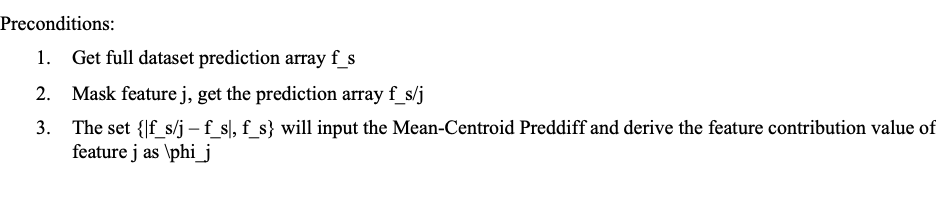

In [14]:
f_s_j = np.array([1,2,3])
f_s = np.array([4,5,6])
preddiff_set = np.transpose((abs(f_s-f_s_j),f_s))
preddiff_set

array([[3, 4],
       [3, 5],
       [3, 6]])

In [ ]:
def normalization(a):
  """log_odd need normalization to [0:1]"""
  norm = np.linalg.norm(a)
  return (a/norm)

def Pred_Diff(orginal_score,mask_score,log_odd_Flag=0):
  """
  difference,log_odd,ab_difference
  """
  if log_odd_Flag == 0:
    diff = orginal_score - mask_score
  elif log_odd_Flag == 1:
    diff = np.log(orginal_score/(1-orginal_score))-np.log(mask_score/(1-mask_score))
  elif log_odd_Flag == 2:
    diff = np.absolute((orginal_score - mask_score))
  return diff


# Mean-Centroid Preddiff Explanation

In [ ]:
feature_number = 6
feature_cluster_number = [3,3,2,3,2,2] #derive from derive_cluster() by dendrogram. six features, for each feature we have a cluster number.
def sub_sample(points, num):
    ind = np.arange(len(points))
    sub_ind = np.random.choice(ind, num, replace=False)
    sub_points = np.array(points)[sub_ind]  # numpy array
     
    return sub_points.tolist()

def data_clean(train_data,data_clean_thrd):
  arr_num = []
  for arr in train_data:
    if arr[0]>data_clean_thrd:
      arr_num.append(arr)
  train_data_clean = np.array(arr_num)
  return train_data_clean

def GMM(train_data,n_components):
  gm = GaussianMixture(n_components=n_components, random_state=0).fit(train_data)
  centroid = gm.means_
  label = gm.predict(train_data)
  prob = gm.predict_proba(train_data)
  return train_data,centroid,label,prob

def calucate_feature_importance(label,centroid):
  d = Counter(label)
  x_sum=y_sum=count=0
  for point in centroid:
    x_sum += point[0]*d[count]
    y_sum += point[1]*d[count]
    count +=1
    c = np.array([x_sum/len(label),y_sum/len(label)])
  return c

def get_angle(point_1, point_2=[0,0]): 
    angle = atan2(abs(point_1[1]) - point_2[1], abs(point_1[0]) - point_2[0])
    angle = degrees(angle)
    return angle

def derive_cluster(score_t,feature):
  data_sample = sub_sample(score_t,1000)
  plt.figure(figsize=(18, 12))
  plt.xlabel('Points in Node',fontsize=24)
  plt.ylabel('Euclidean distances', fontsize=24)
  plt.title("Dendograms of Score Clusters for Feature "+feature,fontsize=24)
  dend = shc.dendrogram(shc.linkage(data_sample, method='ward'))

def plot_scatter(training,centroid,c,feature,label): 
  plt.figure(figsize=(16, 10), dpi=80)
  plt.xlabel('Model Prediction: Orginal Ranking Score',fontsize=20)
  plt.ylabel('PredDiff: $ d = Score_0 - Score\_feature $', fontsize=20)
  plt.scatter(training[:,0],training[:,1],c=label,s=10)
  plt.scatter(centroid[:,0],centroid[:,1],s=500, c='black', alpha=0.7, label = 'Centorid of GMM Cluster')
  plt.scatter(c[0],c[1],s=700, c='r', alpha=0.7, label = 'Centorid from GMM')
  plt.title('PredDiff Distrubtion & Centorid of Feature: '+feature, fontsize=20)
  plt.xticks(size = 24) 
  plt.yticks(size = 24)
  plt.legend(prop={'size': 24})
  plt.show()

def plot_Importance_barchart(feature_importance):
  plt.rcdefaults()
  fig, ax = plt.subplots(figsize=(12, 4), dpi=200)
  feature_names = ('feature_0', 'feature_1','feature_2', 'feature_3')
  y_pos = np.arange(len(feature_names))
  ax.barh(y_pos, feature_importance, align='center')
  ax.set_yticks(y_pos, labels=feature_names)
  ax.invert_yaxis()  # labels read top-to-bottom
  ax.set_xlabel('Feature Importance by Preddiff GMM Clustering Average')

  _, xmax = plt.xlim()
  plt.xlim(-0.5, xmax + 1)
  for i, v in enumerate(feature_importance):
      margin = 0.05
      ax.text(v + margin if v > 0 else margin, i, str(round(v, 4)), color='black', ha='left', va='center')
  plt.show()

def Mean_Centroid_PredDiff_Main(score_training,data_clean_thrd,cluster_num=feature_cluster_number):
  centroid_list=[]
  time_hc = []
  time_scatter = []
  start = time.process_time()
  partition_num = int(len(score_training)/feature_number)
  for i in range(feature_number):
    score_t = score_training[i*partition_num:(i+1)*partition_num]
    # score_t = data_clean(score_t,data_clean_thrd)
    start_hc = time.process_time()
    end_hc = time.process_time()
    time_hc.append(end_hc-start_hc)
    X,centroid,label,_ = GMM(score_t,cluster_num[i])
    c = calucate_feature_importance(label,centroid)
    angel = get_angle(c)
    centroid_list.append(angel)
    start_scatter = time.process_time()
    end_scatter = time.process_time()
    time_scatter.append(end_scatter-start_scatter)
  end = time.process_time()
  time_hc_sum = sum(time_hc)
  time_scatter_sum = sum(time_scatter)
  time_comsuming = [end-start,time_hc_sum,time_scatter_sum]

  return(centroid_list,time_comsuming)


In [ ]:
feature_importance,time_comsuming = Mean_Centroid_PredDiff_Main(preddiff_set)

# Example - Scholar Searching Rank Case study

In [ ]:
# inhouse_data 
# sv_data 
# shap_data 
# pd_data 

In [ ]:
import numpy as np
from sklearn import preprocessing

def nromalized_FI(list):
  list_np = np.array(list).reshape(-1,1)
  print(list_np)
  scaler = preprocessing.MinMaxScaler()
  normalizedlist=scaler.fit_transform(list_np)
  print('Normalized List:',normalizedlist)
  normalizedlist = normalizedlist.reshape(6,40) 
  return normalizedlist.tolist()

pd_data = nromalized_FI(pd_data)
inhouse_data = nromalized_FI(inhouse_data)
sv_data = nromalized_FI(sv_data)
shap_data = nromalized_FI(shap_data)

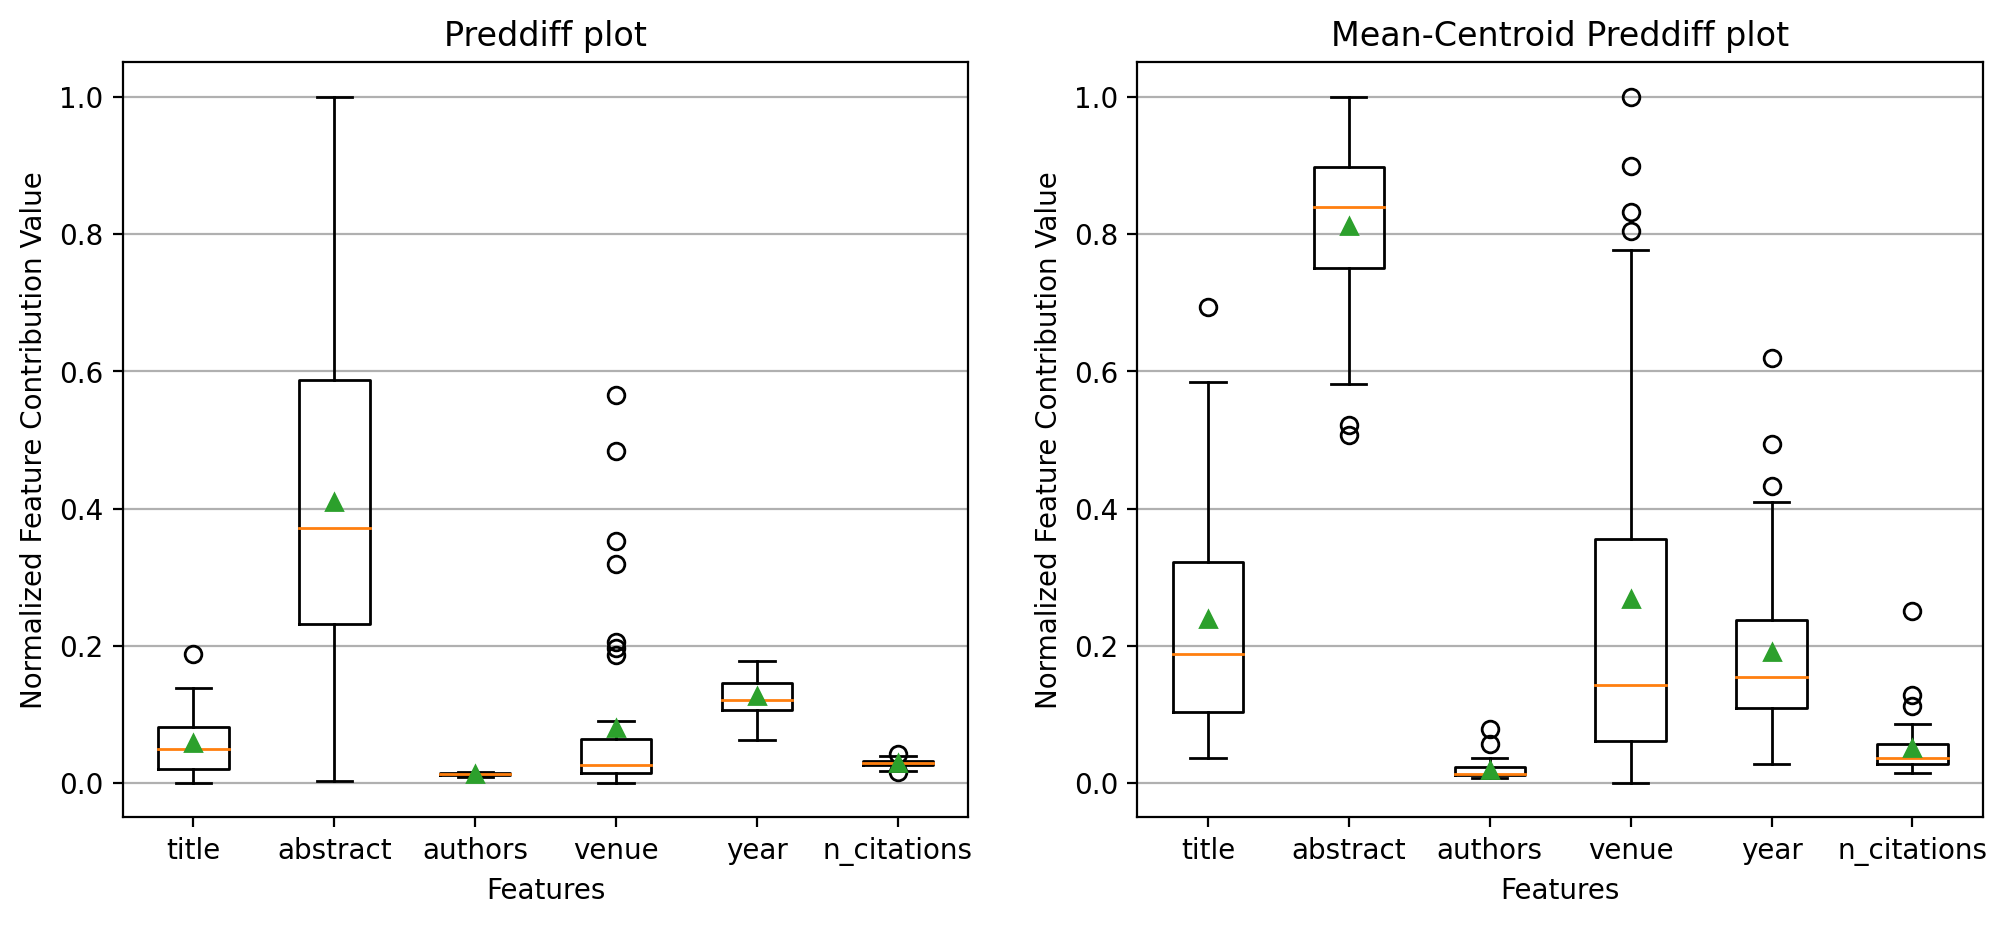

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=200)

# plot violin plot
bp1 = axs[0].boxplot(pd_data,
                  showfliers=True,
                  showmeans=True)
axs[0].set_title('Preddiff plot')

# plot box plot
bp2 = axs[1].boxplot(inhouse_data, 
               showfliers=True, 
               showmeans=True,
               )
axs[1].set_title('Mean-Centroid Preddiff plot')

for ax in axs:
    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(len(sv_data))],
                  labels=['title', 'abstract',  'authors','venue', 'year', 'n_citations'])
    ax.set_xlabel('Features')
    ax.set_ylabel('Normalized Feature Contribution Value')
    # ax.set_yticks(range(-1,2,0.5))

# plt.show()


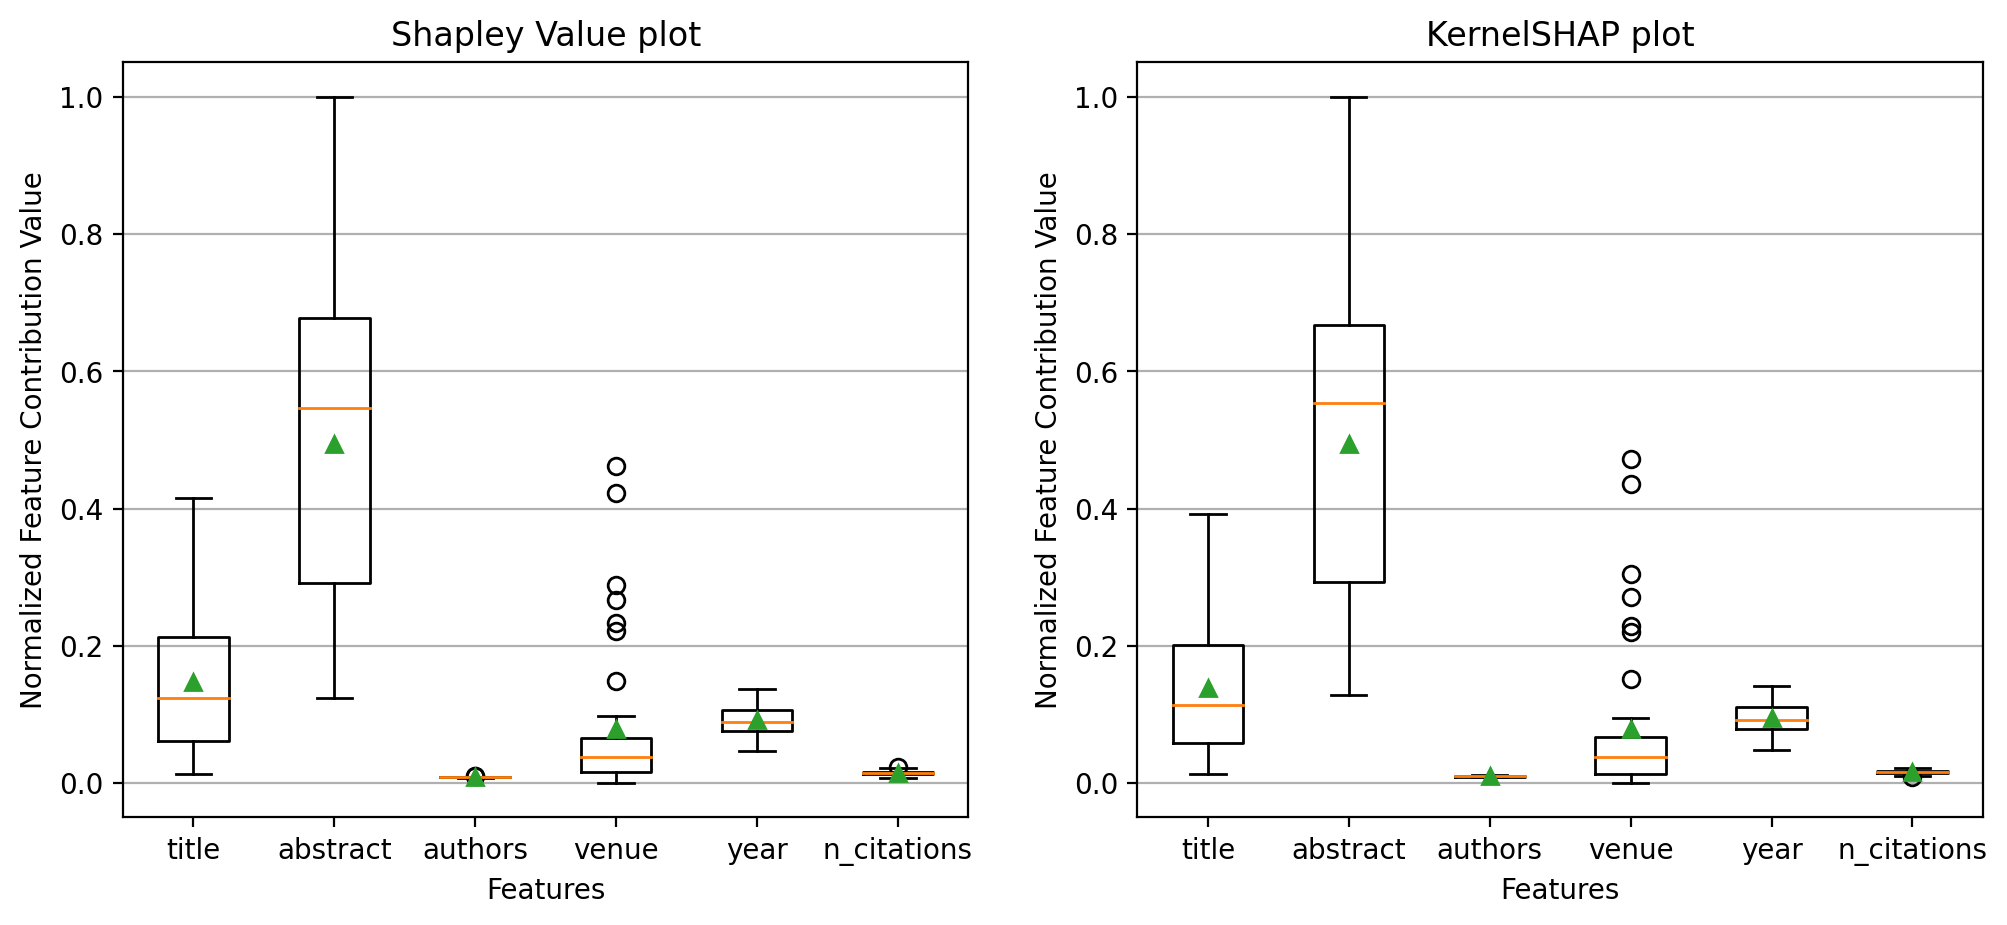

In [ ]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=200)

# plot violin plot
bp1 = axs[0].boxplot(sv_data,
                  showfliers=True,
                  showmeans=True)
axs[0].set_title('Shapley Value plot')

# plot box plot
bp2 = axs[1].boxplot(shap_data, 
               showfliers=True, 
               showmeans=True,
               )
axs[1].set_title('KernelSHAP plot')

for ax in axs:
    ax.yaxis.grid(True)
    ax.set_xticks([y + 1 for y in range(len(sv_data))],
                  labels=['title', 'abstract',  'authors','venue', 'year', 'n_citations'])
    ax.set_xlabel('Features')
    ax.set_ylabel('Normalized Feature Contribution Value')
    # ax.set_yticks(range(-2,20,2))

# plt.show()


# Kendall Tau Ranking Distance

In [ ]:
data

,DataSource(inhouse),title,abstract,authors,venue,year,n_citations,Unnamed: 7,DataSource(sv),title.1,...,year.2,n_citations.2,Unnamed: 23,DataSource(preddiff),title.3,abstract.3,authors.3,venue.3,year.3,n_citations.3
0,cslg,48.398905,79.452413,2.696798,7.676237,40.915571,7.181449,NaN,cslg average_sv,3.194204,...,1.206640,0.148921,NaN,cslg,0.947563,4.510905,0.076971,0.113207,1.230474,0.192584
1,cscv,7.057678,69.728977,2.452362,74.503474,23.520934,9.366140,NaN,cscv average_sv,0.238091,...,1.099870,0.166331,NaN,cscv,0.086344,1.890963,0.099200,2.514773,1.206278,0.276718
2,csai,46.019262,82.824228,2.776134,48.552875,33.937051,7.063760,NaN,csai average_sv,2.318256,...,1.082479,0.156463,NaN,csai,0.148068,1.135042,0.091166,0.161810,1.122888,0.231077
3,csit,24.656877,80.067684,6.528173,82.875781,35.913183,20.774661,NaN,csit average_sv,0.745772,...,0.655974,0.189663,NaN,csit,0.198335,2.473373,0.110740,3.456058,0.730600,0.307354
4,cscl,7.696981,56.125310,0.957158,1.758810,12.779119,2.341791,NaN,cscl average_sv,1.515217,...,1.114594,0.183957,NaN,cscl,0.299394,3.299557,0.090940,0.068238,1.156997,0.242965
5,cscr,9.996593,56.898222,1.007576,10.547508,10.825128,2.408869,NaN,cscr average_sv,1.688565,...,0.929483,0.159340,NaN,cscr,0.350293,3.062284,0.088901,0.371723,1.006280,0.209192
6,csds,7.812151,73.964762,1.778453,3.984908,13.207341,4.439386,NaN,csds average_sv,2.051777,...,0.726389,0.173355,NaN,csds,0.103788,2.632040,0.112191,0.052698,0.791209,0.250583
7,cssy,57.503419,80.682601,4.688683,66.694860,51.284801,10.661558,NaN,cssy average_sv,3.678797,...,1.049239,0.115000,NaN,cssy,0.992245,3.857046,0.084284,1.467241,1.107348,0.162087
8,csni,4.824312,66.817056,0.866531,36.139861,10.382904,2.674291,NaN,csni average_sv,3.298869,...,0.738760,0.164374,NaN,csni,0.000871,0.024084,0.117933,0.007541,0.771571,0.265813
9,csro,5.477721,43.246546,1.213814,68.958391,13.107410,3.069338,NaN,csro average_sv,0.408608,...,1.163559,0.136861,NaN,csro,0.150213,1.461627,0.110512,4.039672,1.192495,0.200100


In [ ]:
inhouse_data = [data['title'].tolist(), data['abstract'].tolist(), data['authors'].tolist(),data['venue'].tolist(),data['year'].tolist(),data['n_citations'].tolist() ]
sv_data = [data['title.1'].tolist(), data['abstract.1'].tolist(), data['authors.1'].tolist(),data['venue.1'].tolist(),data['year.1'].tolist(),data['n_citations.1'].tolist() ]
shap_data = [data['title.2'].tolist(), data['abstract.2'].tolist(), data['authors.2'].tolist(),data['venue.2'].tolist(),data['year.2'].tolist(),data['n_citations.2'].tolist() ]
pd_data = [data['title.3'].tolist(), data['abstract.3'].tolist(), data['authors.3'].tolist(),data['venue.3'].tolist(),data['year.3'].tolist(),data['n_citations.3'].tolist() ]

In [ ]:
import numpy as np

def normalised_kendall_tau_distance(values1, values2):
    """Compute the Kendall tau distance."""
    n = len(values1)
    assert len(values2) == n, "Both lists have to be of equal length"
    i, j = np.meshgrid(np.arange(n), np.arange(n))
    a = np.argsort(values1)
    b = np.argsort(values2)
    ndisordered = np.logical_or(np.logical_and(a[i] < a[j], b[i] > b[j]), np.logical_and(a[i] > a[j], b[i] < b[j])).sum()
    return ndisordered / (n * (n - 1))

def convect_rank(data):
  data = np.array(data).reshape(-1)
  rank_list = []
  for i in range(40):
    rank = []
    for j in range(6):
      rank.append(data[i+40*j])
      tindex = np.argsort(-np.array(rank))
      trank = np.argsort(tindex)
    rank_list.append(trank)
  return rank_list

inhouse_rank = convect_rank(inhouse_data)
sv_rank = convect_rank(sv_data)
shap_rank = convect_rank(shap_data)
pd_rank = convect_rank(pd_data)

def KDT_baseline(basline,sv_rank,inhouse_rank,shap_rank,pd_rank):
  KDT_distance_inhouse = []
  KDT_distance_pd = []
  KDT_distance_shap = []
  KDT_distance_sv = []
  for i in range(len(basline)):
    KDT_distance_inhouse.append(normalised_kendall_tau_distance(basline[i],inhouse_rank[i]))
    KDT_distance_pd.append(normalised_kendall_tau_distance(basline[i],pd_rank[i]))
    KDT_distance_shap.append(normalised_kendall_tau_distance(basline[i],shap_rank[i]))
    KDT_distance_sv.append(normalised_kendall_tau_distance(basline[i],sv_rank[i]))
  return np.transpose((KDT_distance_inhouse, KDT_distance_pd, KDT_distance_shap,KDT_distance_sv))

def KDT_median(sv_rank,inhouse_rank,shap_rank,pd_rank):
  KDT_distance_inhouse = []
  KDT_distance_pd = []
  KDT_distance_shap = []
  KDT_distance_sv = []
  for i in range(len(sv_rank)):
    KDT_distance_inhouse.append(normalised_kendall_tau_distance(np.array([1,0,5,3,2,4]),inhouse_rank[i]))
    KDT_distance_pd.append(normalised_kendall_tau_distance(np.array([1,0,5,4,2,3]),pd_rank[i]))
    KDT_distance_shap.append(normalised_kendall_tau_distance(np.array([1,0,5,3,2,4]),shap_rank[i]))
    KDT_distance_sv.append(normalised_kendall_tau_distance(np.array([1,0,5,2,3,4]),sv_rank[i]))
  return np.transpose((KDT_distance_inhouse, KDT_distance_pd, KDT_distance_shap,KDT_distance_sv))
distance_baseline_sv = KDT_baseline(sv_rank,sv_rank,inhouse_rank,shap_rank,pd_rank)
distance_baseline_inhouse = KDT_baseline(inhouse_rank,sv_rank,inhouse_rank,shap_rank,pd_rank)
distance_baseline_shap = KDT_baseline(shap_rank,sv_rank,inhouse_rank,shap_rank,pd_rank)
distance_baseline_pd = KDT_baseline(pd_rank,sv_rank,inhouse_rank,shap_rank,pd_rank)
distance_median = KDT_median(sv_rank,inhouse_rank,shap_rank,pd_rank)

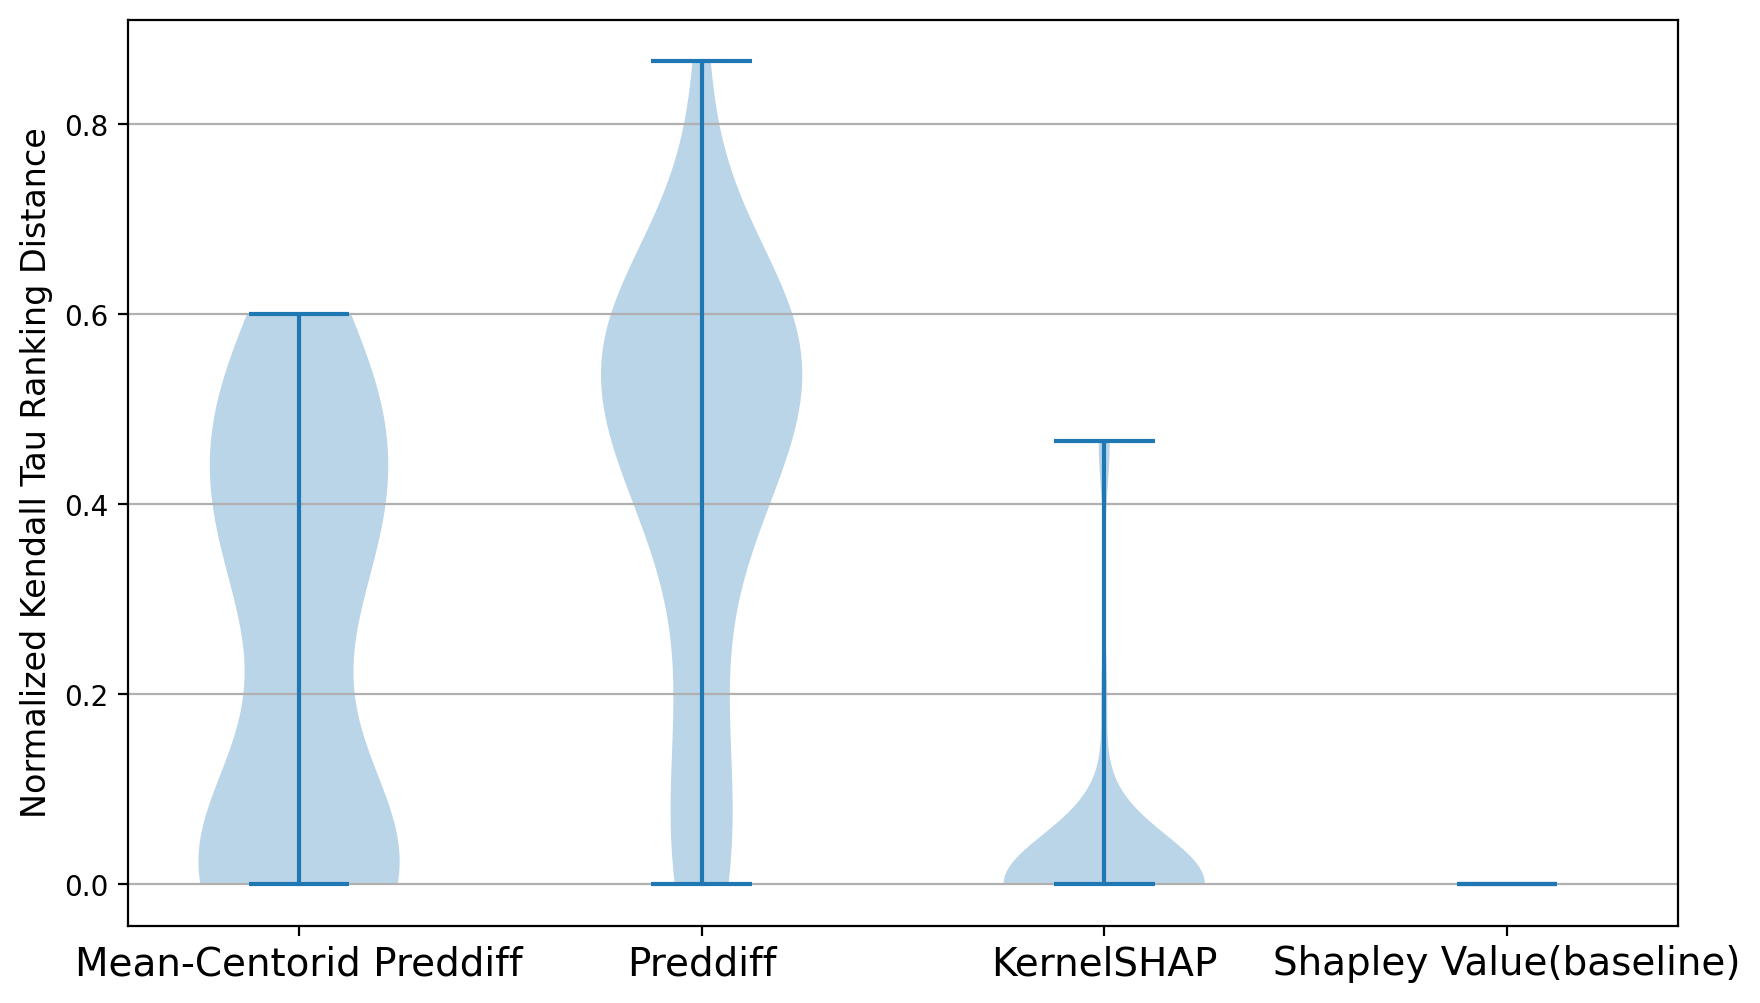

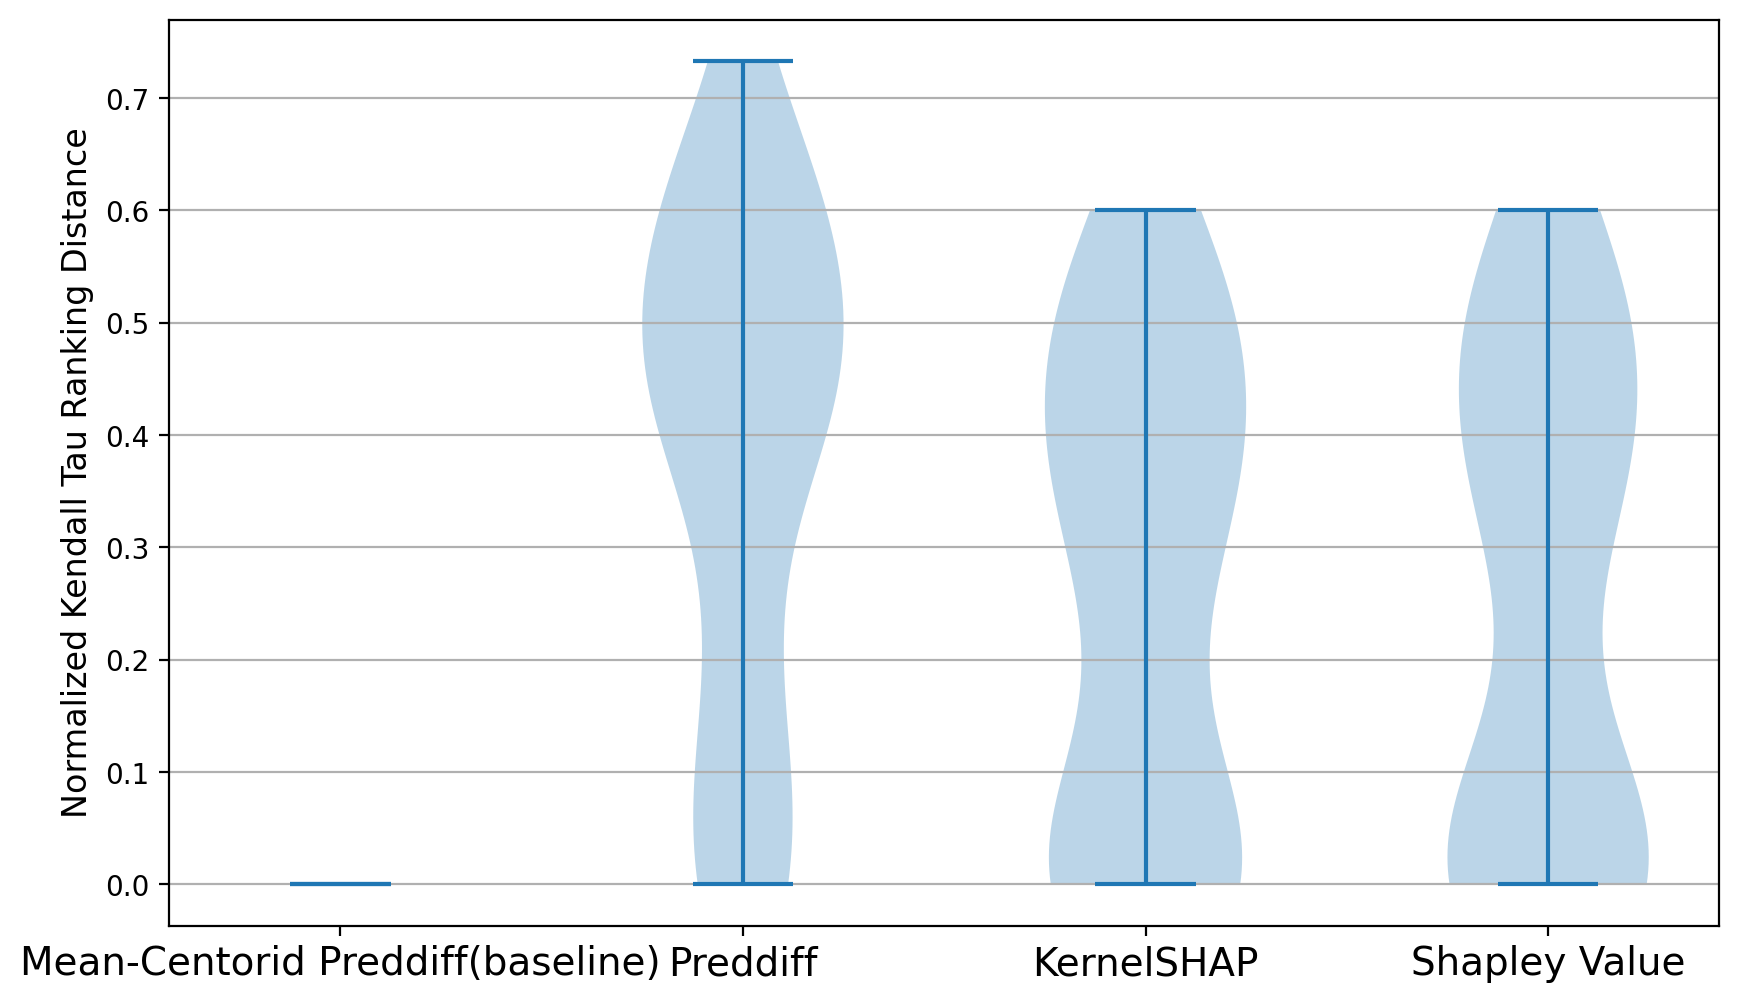

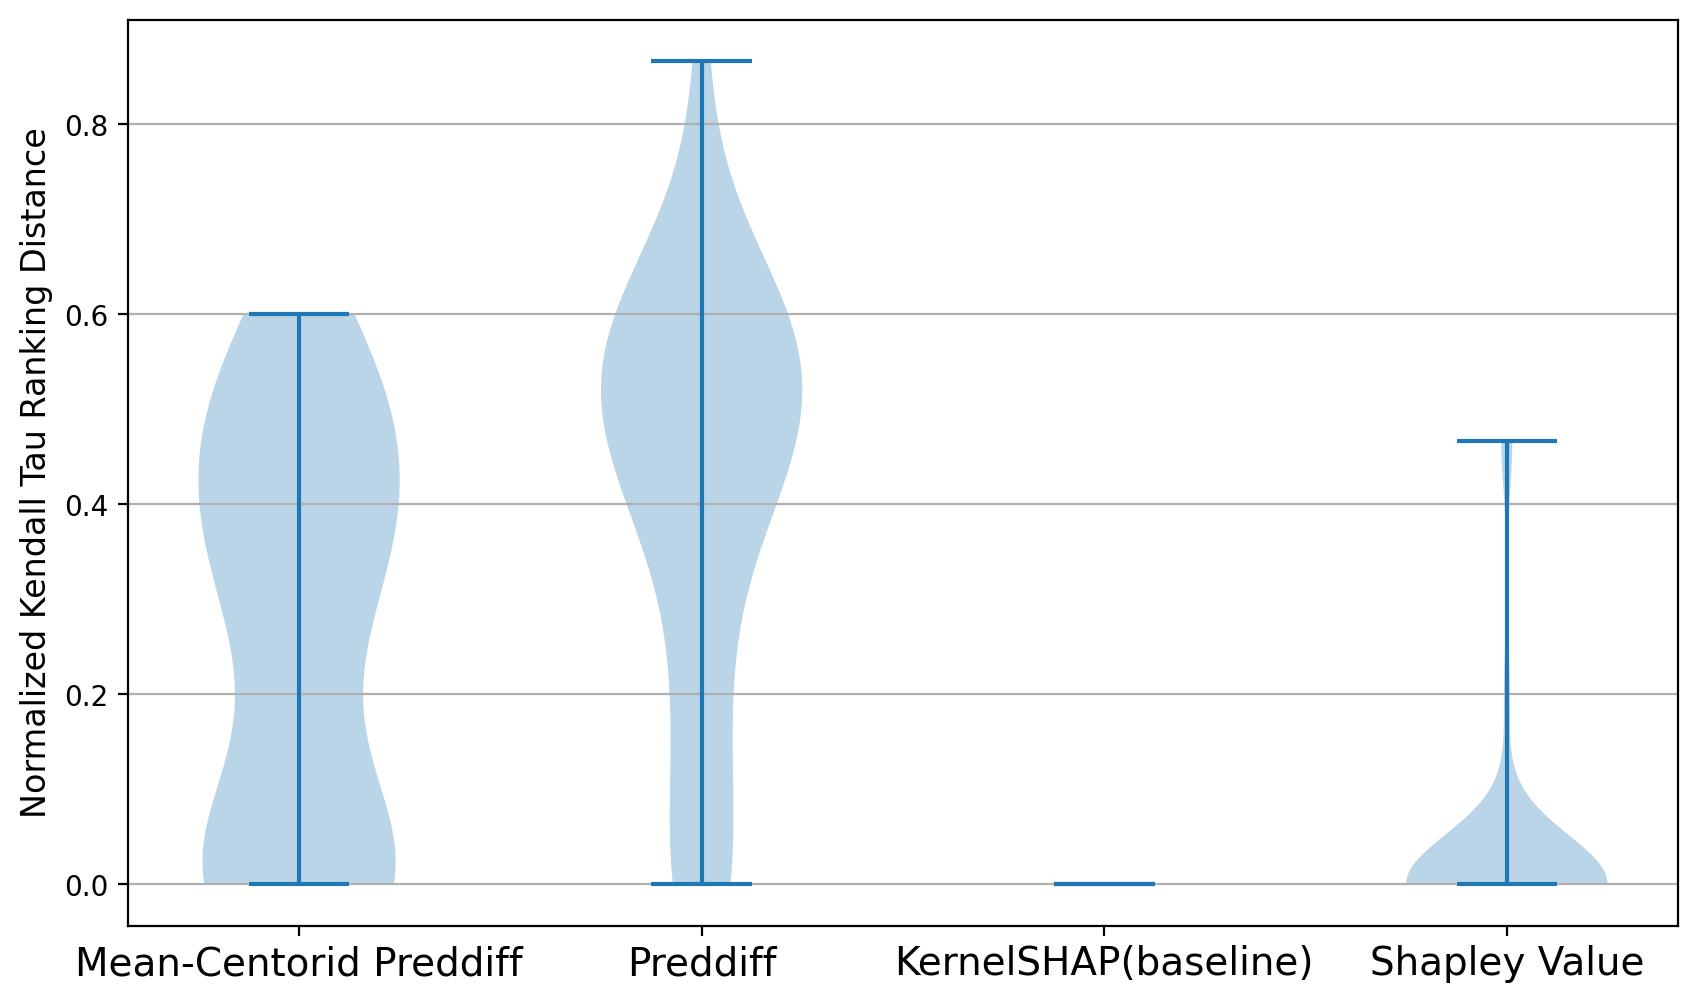

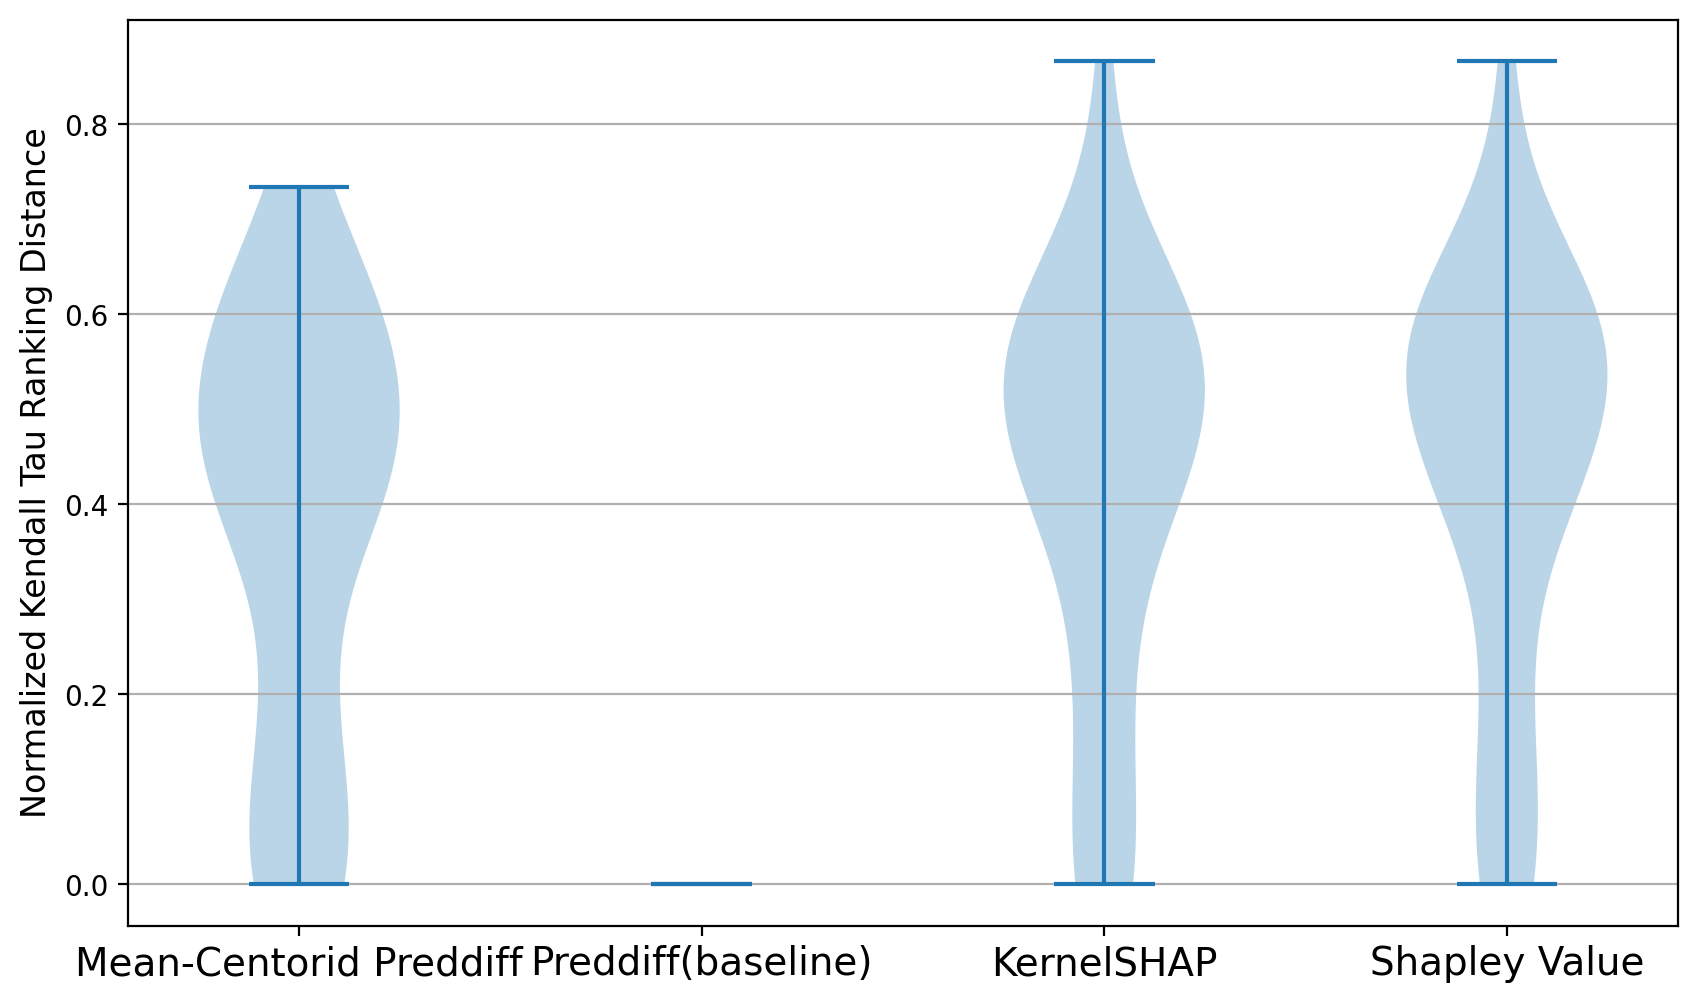

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
def plot_ktrd(d_baseline,labels):
  dbaseline = pd.DataFrame(d_baseline, columns = ['KDT_distance_inhouse', 'KDT_distance_pd', 'KDT_distance_shap','KDT_distance_sv'])
  dbaseline.index = ['cslg','cscv','csai','csit','cscl','cscr','csds','cssy','csni','csro','csdc','cssi','cslo','csna','cscy'
  ,'csdm','csir','csne','csse','cscc','csce','csgr','csmm','csdl','csfl','csma','cspf','csos','csar','cssc','cset'
  ,'csms','csoh','csdb','csgt','cshc','csgl','cspl','cssd','cscg']
  # labels = ['Mean-Centorid Preddiff', 'Preddiff', 'KernelSHAP', 'Shapley Value']
  fig, axes = plt.subplots(figsize=(10, 6), dpi=200)

  axes.violinplot(dataset = [dbaseline["KDT_distance_inhouse"].values,
                            dbaseline["KDT_distance_pd"].values,
                            dbaseline["KDT_distance_shap"].values,
                            dbaseline["KDT_distance_sv"].values] )

  # axes.set_title('Kendall Tau Ranking Distance - Categories vs Median', fontsize=16)
  axes.yaxis.grid(True)
  axes.set_xticks(np.arange(1, len(labels) + 1),labels=labels, fontsize=14)
  # axes.set_xlabel('XAI Methods')
  axes.set_ylabel('Normalized Kendall Tau Ranking Distance', fontsize=12)

  plt.show()


labels = ['Mean-Centorid Preddiff', 'Preddiff', 'KernelSHAP', 'Shapley Value(baseline)']
plot_ktrd(distance_baseline_sv,labels)
labels = ['Mean-Centorid Preddiff(baseline)', 'Preddiff', 'KernelSHAP', 'Shapley Value']
plot_ktrd(distance_baseline_inhouse,labels)
labels = ['Mean-Centorid Preddiff', 'Preddiff', 'KernelSHAP(baseline)', 'Shapley Value']
plot_ktrd(distance_baseline_shap,labels)
labels = ['Mean-Centorid Preddiff', 'Preddiff(baseline)', 'KernelSHAP', 'Shapley Value']
plot_ktrd(distance_baseline_pd,labels)

# RuntimePlotting


o1 r2_score: 0.9425857206
o2 r2_score: 0.9949578744
Preddiff o1 Curve: y = 0.00702 * x + -8.05483
Preddiff o2 Curve: y = 0.00248 * x + 0.0000000577 * x^2 + 24.88965
o1 r2_score: 0.9419618086
o2 r2_score: 0.9947232946
Mean-Centroid Preddiff o1 Curve: y = 0.00702 * x + -3.32690
Mean-Centroid Preddiff o2 Curve: y = 0.00246 * x + 0.0000000580 * x^2 + 29.75954
o1 r2_score: 0.990008037
o2 r2_score: 0.9921077323
Shapley Value o1 Curve: y = 0.03065 * x + -31.37013
Shapley Value o2 Curve: y = 0.02678 * x + 0.0000000492 * x^2 + -3.27413
o1 r2_score: 0.9981331438
o2 r2_score: 0.9981414725
KernelSHAP o1 Curve: y = 0.03128 * x + -12.90840
KernelSHAP o2 Curve: y = 0.03153 * x + -0.0000000032 * x^2 + -14.70697


(0.0, 50000.0)

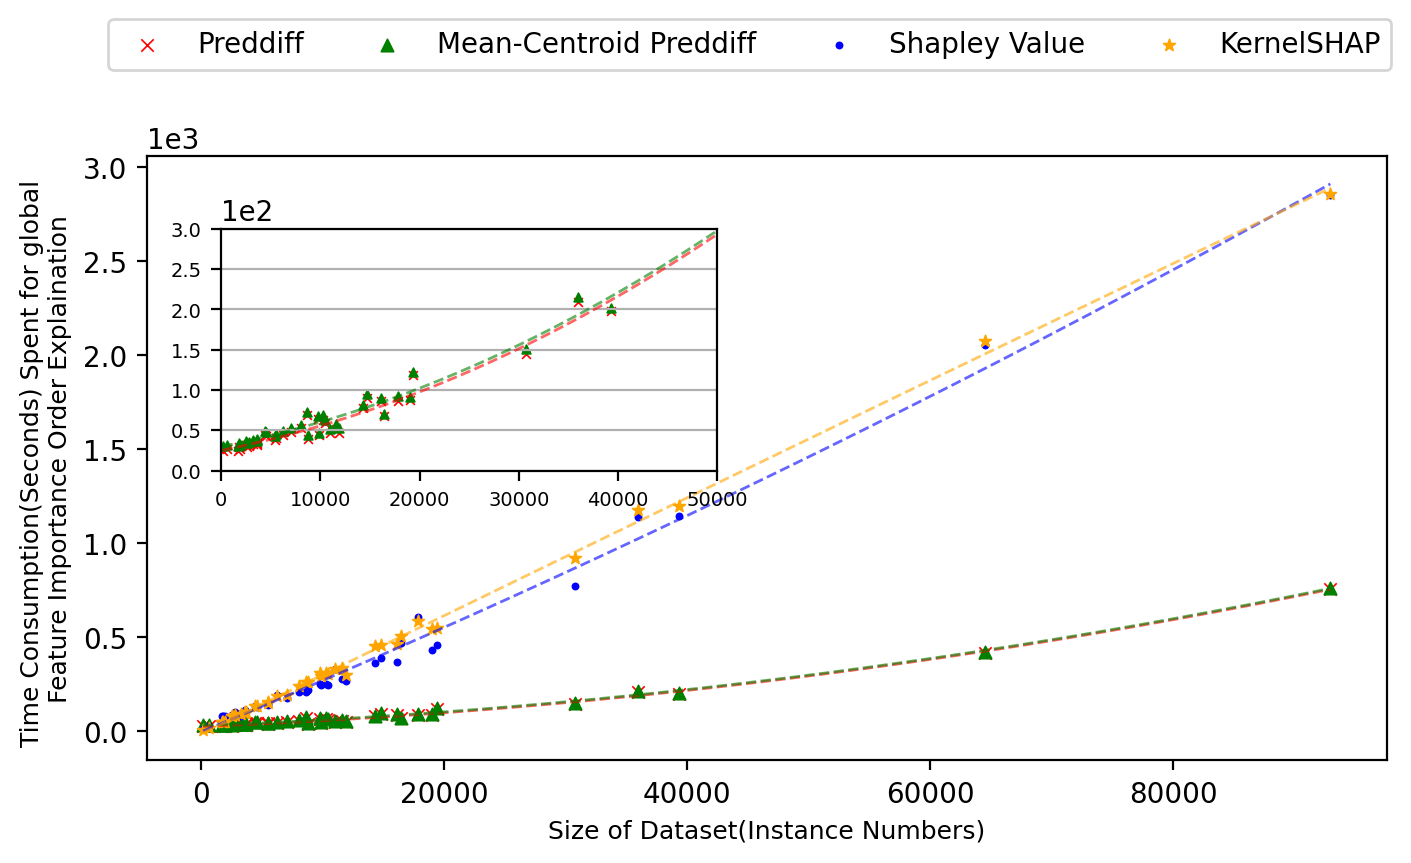

In [ ]:
from scipy.optimize import curve_fit
from sklearn.metrics import r2_score
import matplotlib.pyplot as plt
def objective_1(x, a, c):
	return a * x + c

def objective_2(x, a, b, c):
	return a * x + b * x**2 + c

x = np.flip(time['dataset'])

task = [
	{
		'x': x,
		'y': np.flip(time['pf']),
		'label': 'Preddiff',
		'c': 'red',
		'marker':'x'
	},
 	{
		'x': x,
		'y': np.flip(time['mcpd']),
		'label': 'Mean-Centroid Preddiff',
		'c': 'green',
		'marker':"^"
	},
  	{
		'x': x,
		'y': np.flip(time['sv']),
		'label': 'Shapley Value',
		'c': 'blue',
		'marker':"."
	},
   	{
		'x': x,
		'y': np.flip(time['shap']),
		'label': 'KernelSHAP',
		'c': 'orange',
		'marker':"*"
	},
]

fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(8, 4), dpi=200)
# plt.yscale("log")
# ax.set_xscale("log")
# plt.grid(visible=True, axis='y')

for t in task:    
	ax.scatter(t['x'], t['y'], c=t['c'], s=20, label=t['label'],marker=t['marker'], linewidths=0.6)
	x_line = np.arange(min(x), max(x), 1)
 
	popt_1, _1 = curve_fit(objective_1, x, t['y'])
	y_line_1 = objective_1(x_line, *popt_1)
 
	popt_2, _2 = curve_fit(objective_2, x, t['y'])
	y_line_2 = objective_2(x_line, *popt_2)

	r_square_1 = r2_score(t['y'], [objective_1(x_value, *popt_1) for x_value in x])
	r_square_2 = r2_score(t['y'], [objective_2(x_value, *popt_2) for x_value in x])
 
	print(f'o1 r2_score: {round(r_square_1, 10)}')
	print(f'o2 r2_score: {round(r_square_2, 10)}')
 
	if (r_square_1 > r_square_2):
		ax.plot(x_line, y_line_1, '--', color=t['c'], lw=1, alpha=0.6)
	else:
		ax.plot(x_line, y_line_2, '--', color=t['c'], lw=1, alpha=0.6)
     
	print('%s o1 Curve: y = %.5f * x + %.5f' % (t['label'], *popt_1))
	print('%s o2 Curve: y = %.5f * x + %.10f * x^2 + %.5f' % (t['label'], *popt_2))

 
ax.legend(bbox_to_anchor=(1.015,1.25), loc="best", ncol=4, markerscale=1)
# ax.legend(ncol=4, markerscale=1)
ax.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
ax.set_ylabel('Time Consumption(Seconds) Spent for global \nFeature Importance Order Explaination', fontsize=9)
ax.set_xlabel('Size of Dataset(Instance Numbers)', fontsize=9)
# ax.set_xticks([])
# ax.set_ylim([-200, 20000])
# ax.set_xlim([-200, 20000])

# prediff and mc prediff
# axins = ax.inset_axes([0.6, 0.15, 0.3, 0.3])
axins = ax.inset_axes([0.06, 0.48, 0.4, 0.4])
# axins.set_xscale("log")
# axins.set_xticks([])
axins.tick_params(axis='y', labelsize=7)
axins.tick_params(axis='x', labelsize=7)
axins.grid(visible=True, axis='y')
for t in [t for t in task if t['label'] not in ['Shapley Value', 'KernelSHAP']]:
	axins.scatter(t['x'], t['y'], c=t['c'], s=10, label=t['label'], marker=t['marker'], linewidths=0.6)
	popt, _ = curve_fit(objective_2, x, t['y'])
	x_line = np.arange(min(x), max(x), 1)
	y_line = objective_2(x_line, *popt)
	axins.plot(x_line, y_line, '--', color=t['c'], lw=1, alpha=0.6)
 
axins.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
axins.set_ylim([0, 300])
axins.set_xlim([0, 50000])

# # sv and shap
# axins2 = ax.inset_axes([0.06, 0.48, 0.4, 0.4])
# # axins2.set_xscale("log")
# # axins2.set_xticks([])
# axins2.tick_params(axis='y', labelsize=7)
# axins2.tick_params(axis='x', labelsize=7)
# axins2.grid(visible=True, axis='y')
# for t in [t for t in task if t['label'] in ['Shapley Value', 'KernelSHAP']]:
# 	axins2.scatter(t['x'], t['y'], c=t['c'], s=10, label=t['label'], marker='x', linewidths=0.6)
# 	popt, _ = curve_fit(objective_2, x, t['y'])
# 	x_line = np.arange(min(x), max(x), 1)
# 	y_line = objective_2(x_line, *popt)
# 	axins2.plot(x_line, y_line, '--', color=t['c'], lw=1, alpha=0.6)
 
# axins2.ticklabel_format(axis='y', style='sci', scilimits=(0,0))